In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import csv
from pybedtools import BedTool
import pybedtools
from scipy.stats import gaussian_kde
from scipy.stats import zscore
pybedtools.set_tempdir('./')
from scipy.cluster.hierarchy import dendrogram, linkage
#import seaborn as sns


### Change settings: MIN_N is the minimum number of mu values at this position; D is the distance to merge mu
MIN_N = 12    ### The minimum number of observations in each region
D = 5        ### The distance that bedtools should use to merge values of mu
#MAXZ = 3     ### The Z score at which to report outliers at each position

def main():  
    
    ### Set up the directories and the gene file
    file_filter = ".bed"
    #INPUT_DIR = '/media/ab/data/Research_Data/3primeEnd/'
    INPUT_DIR = '/media/ab/data/Research_Data/humanMouseHomology/MouseEMG/'
    OUTPUT_DIR = '/media/ab/data/Research_Data/humanMouseHomology/'
    #INPUT_DIR = '/media/ab/data/Research_Data/3primeEnd/'
    #GENES_BED = '/media/ab/data/Research_Data/findMu/hg19.refseqgenes.merged.bed'
    if INPUT_DIR[-1] != '/':
        INPUT_DIR = INPUT_DIR + '/'
    OUTPUT_DIR = createOutputFolder(OUTPUT_DIR+'OUT_'+str(D)+'_'+str(MIN_N)+'/')
    if OUTPUT_DIR[-1] != '/':
        OUTPUT_DIR = OUTPUT_DIR + '/'
    print "Input directory is: ", INPUT_DIR
    print "Output directory is: ", OUTPUT_DIR
    
    ### Open the files in the input directory and load the data from the bed files
    allData = dict()
    dir_list = sorted(os.listdir(INPUT_DIR))
    for FILENAME in dir_list:
        if FILENAME[-(len(file_filter)):] == file_filter:      ### Load only the TSV files
            allData[FILENAME] = loadFromFile(INPUT_DIR+FILENAME)
    
    ### Calculate the total coverage for each dataset
    coverage = dict()
    for fileName in sorted(allData.keys()): 
        coverage[fileName] = calculateCoverage(allData[fileName])
    
    ### Filter the list of datasets within a certain range of coverage
    coverage = filterOnCoverage(coverage, .1, .1)
    print "allData length :", len(allData)
    
    ### Remove datasets with unacceptable coverage
    for key in allData.keys():
        if key not in coverage.keys():
            allData.pop(key)
    print "allData length :", len(allData)
    
    
    ### Open each set of data and add the values of mu and pi to the list
    bedGraphAll = []
    for fileName in sorted(allData.keys()):
        bedGraph = makeBedgraph(allData[fileName], fileName)
        bedGraphAll += bedGraph
        #saveDataToText(OUTPUT_DIR, fileName[:-len(file_filter)]+'.bedgraph', bedGraph)

    ### Merge the regions of mu and collapse the values of pi into a delimited list
    pyBedGraph = BedTool(bedGraphAll)
    print 'Total number of regions: ', len(bedGraphAll)
    pyBedGraphMerged = pyBedGraph.sort().merge(d=D, c=4, o='collapse', delim=";")
    print 'Number of regions after merge: ', len(pyBedGraphMerged)
    
    ### Open the intervals for the genes (should be merged first)
    #genesBed = BedTool(GENES_BED)
    #print "Number of gene regions: ", len(genesBed)
    
    ### Save all data to file
    saveDataToText(OUTPUT_DIR, 'collapsedMu.txt', pyBedGraphMerged)
    pyBedGraphMu = BedTool(findMiddleMu(pyBedGraphMerged))
    saveDataToText(OUTPUT_DIR, 'averageMu.bed', pyBedGraphMu)
    #pyBedGraphMergedGenes = pyBedGraphMu.intersect(genesBed, u=True)
    #saveDataToText(OUTPUT_DIR, 'averageMuGenes.txt', pyBedGraphMu)
    
    
    '''
    ### Create copy of merged reasons for genes and nongenes
    pyBedGraphMergedGenes = pyBedGraphMerged.saveas()
    pyBedGraphMergedNonGenes = pyBedGraphMerged.saveas()
    pyBedGraphMergedMatrix = pyBedGraphMerged.saveas()
    pyBedGraphMergedMatrixGenes = pyBedGraphMerged.saveas()
    pyBedGraphMergedMatrixNonGenes = pyBedGraphMerged.saveas()

    
    ### Identify mu values that intersect with genes
    pyBedGraphMergedGenes = pyBedGraphMergedGenes.intersect(genesBed, u=True)
    pyBedGraphMergedNonGenes = pyBedGraphMergedNonGenes.intersect(genesBed, v=True)    
    pyBedGraphMergedMatrixGenes = pyBedGraphMergedMatrixGenes.intersect(genesBed, u=True)
    pyBedGraphMergedMatrixNonGenes = pyBedGraphMergedMatrixNonGenes.intersect(genesBed, v=True)       
    
    ### Testing the matrix feature
    getDatasetOutliers(OUTPUT_DIR, 
                       'datasetMatrix_'+str(D)+'_'+str(MIN_N), 
                       pyBedGraphMergedMatrix, 
                       3, 
                       sorted(allData.keys()))
    
    getDatasetOutliers(OUTPUT_DIR, 
                       'datasetMatrixGenes_'+str(D)+'_'+str(MIN_N), 
                       pyBedGraphMergedMatrixGenes, 
                       3, 
                       sorted(allData.keys()))
    
    getDatasetOutliers(OUTPUT_DIR, 
                       'datasetMatrixNonGenes_'+str(D)+'_'+str(MIN_N), 
                       pyBedGraphMergedMatrixNonGenes, 
                       3, 
                       sorted(allData.keys()))
    
    ### Get data from merged data and graph for all regions, genes and non-genes
    calculateAndGraphVariance(OUTPUT_DIR, 'all_regions_'+str(D)+'_'+str(MIN_N), pyBedGraphMerged)    
    calculateAndGraphVariance(OUTPUT_DIR, 'genes_'+str(D)+'_'+str(MIN_N), pyBedGraphMergedGenes)
    calculateAndGraphVariance(OUTPUT_DIR, 'nogenes_'+str(D)+'_'+str(MIN_N), pyBedGraphMergedNonGenes)
    '''
    pybedtools.cleanup()
    return None

def calculateAndGraphVariance(directory, filename, pyBedGraph):
    
    graphData = dataFromBedTool(pyBedGraph, 3)
    if len(graphData[0]) <= 0:
        print "There are no results that match your criteria: ", filename, " Exiting this operation."
        return None
    
    ### Sort the data and data labels
    x = [X for (X,Y) in sorted(zip(graphData[0],graphData[1]), key=lambda q: (np.median(q[1])))] 
    y = [Y for (X,Y) in sorted(zip(graphData[0],graphData[1]), key=lambda q: (np.median(q[1])))] 
    
    ### Calculate the means and variance for y data
    yM = [('%0.10f' % np.median(q)) for q in y]
    yVariance = [('%0.10f' % np.var(q)) for q in y]
    
    ### Graph the value of pi by the variance
    makeVarianceGraph(directory, filename, yM, yVariance)
    
    ### Graph the distributions at each mu with the variance
    makeMuGraph(directory, filename, x, y, yVariance)

    ### Calculate number of observations
    N = len(x)

    ### Find outliers
    outliers = getPiOutliers(y,MAXZ)
    
    ### Save the data to a text file
    saveDataToText(directory, filename+'.txt', zip(x,yM, yVariance, y, outliers))

    return None

def stringToTuple(string):
    
    splitString = string.split(',')
    output = (splitString[0][1:].strip("'").strip(), splitString[1][:-1])
    return output

def createOutputFolder(new_folder):

    # Checks to see if a directory exists, and if not, makes the directory. It
    # returns the directory path as output

    if not os.path.exists(new_folder):
        os.mkdir(new_folder)
    return new_folder

        
def filterOnCoverage(coverage, bottomPercentage, topPercentage):
    
    remove = []
    print 'coverage length', len(coverage)
    print 'max', max(coverage.iterkeys(), key=(lambda key: coverage[key]))
    print 'min', min(coverage.iterkeys(), key=(lambda key: coverage[key])) 
    remove = sorted(coverage, key=coverage.get)[:int(len(coverage) * bottomPercentage)]
    remove += sorted(coverage, key=coverage.get)[int(len(coverage) * (1-topPercentage)):]
    for k in remove:
        coverage.pop(k, None)
    print "new length of coverage: ", len(coverage)
    #print 'new sorted values', sorted(coverage.values())
    return coverage
                  
def makeBedgraph(intervalList, ID):
    
    bedgraph = []
    for interval in intervalList:
        start = int(float(interval[3]))
        mu = str((ID, (float(interval[3]))))
        bedgraph.append([interval[0], start, start+1, mu])
    return bedgraph
        
def calculateCoverage(intervalList):
    
    cov = 0
    for interval in intervalList:
        cov += (int(interval[2]) - int(interval[1]))
    return cov
    
def loadFromFile(file_to_open):    

    x=openFile(file_to_open)   ### Open the file
    data = []                    ### Initiate the data list
    position = ['', 0, 0, 0, 0, 0, 0, 0]               ### Initate the dict for each genomic interval
    for line in x:               ### For each line in the file x
        if line[0] == '#':
            continue
        position[0] = line.strip('\n').split('\t')[0] ### Chromosome
        position[1] = line.strip('\n').split('\t')[1] ### Start
        position[2] = line.strip('\n').split('\t')[2] ### End
        middle = np.mean([int( position[1] ),int( position[2])])
        #print middle
        parameterLine = line.strip('\n').split('\t')[3].split('|')[1].split(',') ### All the parameters
        #print parameterLine
        position[3] = parameterLine[0] ### Mu
        position[4] = parameterLine[1] ### Sigma
        position[5] = parameterLine[2] ### Lambda
        position[6] = str(parameterLine[3]) ### Pi
        position[7] = int(float(position[3]) - middle) ### Mu offset from middle of BTE region
        data.append(position)               ### Append the interval dict to the data list                
        #print position
        position = ['', 0, 0, 0, 0, 0, 0, 0]                  ### Reset the position
    #x.close()
    return data            
    ### End of function

def openFile(fileName):
        
    data = open(fileName)
    return data
   
    ### End of function    

    
def dataFromBedTool(data, column):
    
    values = []
    labels = []
    for i in data:
        if len(i[column].split(';')) >= MIN_N:
            values.append([float(stringToTuple(j)[1]) for j in (i[column]).split(';')])
            labels.append(str(i[0]+":"+i[1]+"-"+i[2]))
    #print "out :", len(out), out
    return labels, values

    ### End of function   

def makeMatrix(x,y,z):

    # Creates a list y long containing lists of x elements z
    Matrix = [[z for i in range(x)] for j in range(y)] 
    return Matrix

    '''
    def findMiddleMu(bedgraphTool):
    
    print "number of lines: ", len(bedgraphTool)
    if len(bedgraphTool) <= 0:
        print "There aren't any positions"
    newBedGraph = []
    for line in bedgraphTool:
        muValues = line[3].split(';')
        if len(muValues) >= MIN_N:
            newLine = []
            muList = []
            for value in muValues:
                valueTup = stringToTuple(value)
                muList.append(float(valueTup[1]))
            newBedGraph.append([line[0], line[1], line[2], str(int(round(np.mean(muList))))])
    
    return newBedGraph
    ### End of function   
    '''

def findMiddleMu(bedgraphTool):
    
    print "number of lines: ", len(bedgraphTool)
    if len(bedgraphTool) <= 0:
        print "There aren't any positions"
    newBed = []
    for line in bedgraphTool:
        muValues = line[3].split(';')
        if len(muValues) >= MIN_N:
            newLine = []
            muList = []
            for value in muValues:
                valueTup = stringToTuple(value)
                muList.append(float(valueTup[1]))
            start = str(int(round(np.mean(muList))))
            newBed.append([line[0], start, str(int(start)+1)])
    
    return newBed
    ### End of function   

    
def getDatasetOutliers(directory, filename, allDataBedTool, maxZ, fileList):
    
    ''' This should be a heatmap with the position on the long axes, the dataset on the other, and each value
    is either -1 (nothing found), 0 (same as the others), or 1 (different than the others). Maybe we'll see
    a particular dataset that is different than the others. 
    '''
    print "number of lines: ", len(allDataBedTool)
    print "number of files: ", len(fileList)
    if len(allDataBedTool) <= 0:
        print "There aren't any positions"
    
    empty = -1
    typical = 0
    unique = 1
    
    ### Create the matrix with values of -1
    #matrix = makeMatrix(len(fileList), len(allDataBedTool), -1)
    matrix = []
    print "created the matrix"
    
    ### Create a lookup dict for the value of each filename
    fileDict = dict()
    c = 0
    for i in sorted(fileList):
        fileDict[i]=c
        c+=1
    print "created the file index dict"
    
    positions = []
    positionCount = 0
    for line in allDataBedTool:
        #splitLine = line.split('\t')
        piValues = line[3].split(';')
        if len(piValues) >= MIN_N:
            newRow = [empty for q in range(len(fileList))]
            datasetList = []
            valueList = []
            for value in piValues:
                valueTup = stringToTuple(value)
                datasetList.append(str(valueTup[0]))
                valueList.append(float(valueTup[1]))
            zScoreList = zscore(valueList)
            for i in range(len(zScoreList)):
                if newRow[fileDict[datasetList[i]]] == unique:
                    continue
                if abs(zScoreList[i]) >= MAXZ:
                    newRow[fileDict[datasetList[i]]] = unique
                else:
                    newRow[fileDict[datasetList[i]]] = typical
            matrix.append(newRow)
            positions.append(str(line[0]+":"+line[1]+"-"+line[2]))
            positionCount += 1
        
    print "populated the matrix"
    print "matrix dimensions: ", len(matrix[0]), len(matrix)
    #for i in range(len(splitLine[3].split(';'))):
            
    #saveDataToText(directory, filename, matrix)
    matrixMap(directory, filename, fileList, positions, matrix)
    #        if abs(z[i]) >= maxZ:
    #            vals.append(x[i])
    #    outliers.append(vals)
    #print matrix
    #return matrix
    ### End of function   

    
def clusterMatrix(ax, matrix, labels):
    
    d = linkage(matrix, 'ward')
    dendout = dendrogram(d,
                         leaf_rotation=90,
                         leaf_font_size=6,
                         orientation='left',
                         no_labels=True,
                         ax=ax)
                         #leaf_label_rotation=90,
                         
    newMatrix = []
    newLabels = []
    #print 'dendout ivl', dendout['ivl']
    for i in dendout['ivl']:
        newMatrix.append(matrix[int(i)])
        newLabels.append(labels[int(i)])
    return ax, newMatrix, newLabels
    
def matrixMap(directory, filename, xLabels, yLabels, dataMatrix):
    
   
    print "Making the heatmap"
    #N = len(xLabels)
    #print "Number of positions :", xLabels
    
    ### Create a range of numbers for the x axis
    xNum = range(len(xLabels))
    xNum = [i+.5 for i in xNum]
    yNum = range(len(yLabels))
    yNum = [i+.5 for i in yNum]
    ### Create the figure and subplot positions
    vSize = int(4+(.2*len(xLabels)))
    hSize = int(5+(.15*len(yLabels)))
    #vSize = 20
    #hSize = 150
    print "hsize", hSize, "vSize", vSize
    fig = plt.figure(figsize=(hSize, vSize))
    #ax1 = plt.subplot2grid((1, 1), (0, 0))
    #ax2 = plt.subplot2grid((3, 1), (1, 0), rowspan=2)
    ax2 = plt.subplot2grid((1, 40), (0, 0))
    ax1 = plt.subplot2grid((1, 40), (0, 1), colspan=39)

    dataMatrix=np.array(dataMatrix).T
    ax2, dataMatrix, xLabels = clusterMatrix(ax2, dataMatrix, xLabels)
    
    ### Plot the variance in axes 1
    #im = sns.heatmap(dataMatrix)
    im = ax1.pcolormesh(dataMatrix, cmap='gist_heat')  # Plot the variance data
    #fig.colorbar(im)
    plt.colorbar(im, ax=ax1, ticks=[-1,0,1], pad = 0)

    ax1.xaxis.tick_top()
    #ax1.set_ylabel('Dataset')
    ax1.set_xlabel('Position of mu')
    ax1.set_xlim(left=0, right=len(yLabels)) 
    ax1.set_ylim(bottom=0, top=len(xLabels))   
    ax1.set_yticks(xNum)            
    ax1.set_xticks(yNum)
    ax1.set_yticklabels(xLabels, rotation="horizontal", fontsize=6, va='center') #, ha="left")
    ax1.set_xticklabels(yLabels, rotation="vertical", fontsize=6, ha="center")
    ax1.tick_params(direction='out')
    ax2.set_xticks([])
    
    plt.tight_layout()
    ### Finalize the plot
    fig.suptitle(filename+"  N="+str(len(yLabels)), y=1.05, fontsize=12)
    #plt.subplots_adjust(wspace=0, hspace=0)    
    
    ### Set the plots and show
    #plt.savefig(directory+filename+"_heatmap.svg",format='svg')
    plt.savefig(directory+filename+"_heatmap.png",format='png')
    plt.show()

    return
    
def getPiOutliers(values, maxZ):
    outliers = []
    for x in values:
        vals = []
        z = zscore(x)
        for i in range(len(z)):
            if abs(z[i]) >= maxZ:
                vals.append(x[i])
        outliers.append(vals)
    return outliers
    ### End of function   


def makeVarianceGraph(directory, filename, m, variance):
    
    ### Calculate means and variance
    x = [float(x) for x in m]
    y = [float(y) for y in variance]
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    
    ### Plot means vs 
    fig = plt.figure(figsize=(3, 3))
    ax3 = plt.subplot2grid((1, 1), (0, 0), rowspan=1, colspan=1)
    ax3.scatter(m, variance, c=z, edgecolor='')
    ax3.set_xlim(left=-1, right=1)   
    ax3.set_ylim(bottom=0, top=0.6)
    ax3.set_ylabel('Variance')
    ax3.set_xlabel('Median value of Pi')     
    ax3.set_xticks(range(-1,2,1))
    
    ### Add the title
    fig.suptitle(filename+"  N="+str(len(m)), y=1.00, fontsize=10)
    
    ### Set the plots and show
    plt.tight_layout()
    plt.savefig(directory+filename+"_PiVariance_"+".svg",format='svg')
    plt.savefig(directory+filename+"_PiVariance_"+".png",format='png')
    plt.show()
        
def makeMuGraph(directory, filename, x, y, yVariance):
    
    N = len(x)
    print "Number of positions :", N
    
    ### Create a range of numbers for the x axis
    xNum = range(N)
       
    ### Create the figure and subplot positions
    fig = plt.figure(figsize=(60, 6))
    ax1 = plt.subplot2grid((3, 1), (0, 0))
    ax2 = plt.subplot2grid((3, 1), (1, 0), rowspan=2)
    
    ### Plot the variance in axes 1
    ax1.plot(xNum, yVariance)  # Plot the variance data
    ax1.xaxis.tick_top()
    ax1.set_ylabel('Variance by position')
    ax1.set_ylim(bottom=0, top=.5)   
    ax1.set_xlim(left=0, right=N) 
    
    ### Plot the distribution of pi values in axes 2
    for xe, ye in zip(xNum, y):
        ax2.scatter([xe] * len(ye), ye, s=1)     # Zip the data together and plot scatters
    ax2.set_xticks(xNum)            
    ax2.set_yticks(range(-1,2,1))
    ax2.set_xticklabels(x, rotation="vertical", fontsize=8, ha="left")
    ax2.set_ylim(bottom=-1, top=1)   
    ax2.set_xlim(left=-1, right=N)   
    ax2.yaxis.grid(True, which="major", linestyle='-', color='grey')
    ax2.set_ylabel('Pi (-1 to 1)')

    ### Finalize the plot
    fig.suptitle(filename+"  N="+str(N), y=0.98, fontsize=12)
    plt.subplots_adjust(wspace=0, hspace=0.1)    
    
    ### Set the plots and show
    plt.savefig(directory+filename+".svg",format='svg')
    plt.savefig(directory+filename+".png",format='png')
    plt.show()

def saveDataToText(directory, name, data):

    # Save the line data to an output text file in the same directory as the graphs

    # Create writer
    ofile  = open(directory+name, "wb")
    writer = csv.writer(ofile, delimiter='\t')
    
    # Write each line
    for line in data:
        outLine = []
        for i in line:
            outLine.append(i)
        writer.writerow(outLine)

    # Close the file
    ofile.close()
    return            
    ### End of function


if __name__ == "__main__":
    sys.exit(main())

Input directory is:  /media/ab/data/Research_Data/humanMouseHomology/MouseEMG/
Output directory is:  /media/ab/data/Research_Data/humanMouseHomology/OUT_5_12/
coverage length 68
max SRR930686_fullModel-2_divergent_classifications.bed
min SRR930716_fullModel-2_divergent_classifications.bed
new length of coverage:  55
allData length : 68
allData length : 55
Total number of regions:  1726070
Number of regions after merge:  945732
number of lines:  945732


SystemExit: 

To exit: use 'exit', 'quit', or Ctrl-D.


In [51]:

##cat *.bedgraph | bedtools sort -i stdin | bedtools merge -i stdin -c 4 -o collapse > collapsedByPosition.txt

## First, sort the positions by the average pi
## Then plot them on a graph across with each data point both above and below the line. 
## This will be a good start, but they can be clustered using merge to get broader regions to see if that changes the results
## Can also filter based on the number of observations


    ### To start, use the TSS position as the center, and look at the position of mu relative to it. Don't use the
    ### position of mu relative to the bidirectional region

SyntaxError: invalid syntax (<ipython-input-51-06694d24dd81>, line 1)

In [62]:
print range(4)

[0, 1, 2, 3]


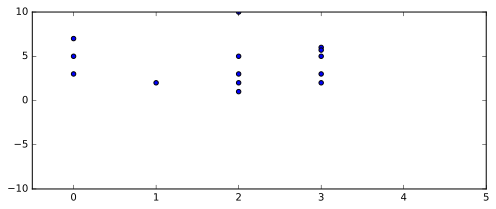

In [77]:
x = '0,1,2,3,4,5'
x = x.split(',')
x = [ int(i) for i in x ]

#x = [0,1,2,3]
y = [[3,5,7],[2],[1,5,3,2,10],[3,5,6,2,5.7]]
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(7, 3))
for xe, ye in zip(x, y):
    ax1.scatter([xe] * len(ye), ye)
plt.xticks(x)
plt.yticks(range(-10,11,5))
ax1.set_ylim(bottom=-10, top=10)
plt.tight_layout()
plt.show()
#ax1.scatter(x, y)

In [89]:
i = [['chr1', 23, 45],['chr1', 233, 445],['chr1', 2343, 4355],['chr1', 23254, 43345]]
x = BedTool(i)
#z = BedTool(x[0:3])
#x.head(2)
#out = []
#for q in x:
#    line = []
#    for j in q:
#        line.append(j)
#    print line
#    out.append(line)
print len(x)
#print x[0:2]
z = x.sample(n=2)
print z
for i in z:
    print i[2]
#print z
print len(x)
#print len(z)
#print out

    #print x[1]
#print x
#print z[1][1]
#print z[1]

4
chr1	23	45
chr1	233	445

45
445
4


In [186]:
i = [[-100, -233, -445],[94559, 23254, 43345],[32, 23, 45],[3452, 2343, 4355]]
j = ['med-low', 'high', 'low', 'med-high']
k = [0,1,2,3]
#print [X for (Y,X) in sorted(zip(i,j), key=lambda pair: np.mean(pair[0]))] 
#print [Y for (Y,X) in sorted(zip(i,j), key=lambda pair: np.mean(pair[0]))] 
for a,b in zip(k,i):
    print [a]*len(b)
    print b
#i = sorted(i, key=lambda q: np.mean(q))
#print i
#print np.ptp(i[0])

[0, 0, 0]
[-100, -233, -445]
[1, 1, 1]
[94559, 23254, 43345]
[2, 2, 2]
[32, 23, 45]
[3, 3, 3]
[3452, 2343, 4355]


In [18]:
i = [[69, 23, 45],[994, 233, 445],[2453, 2343, 4355],[54646, 23254, 43345]]
x = BedTool(i)
print len(x)
z = x.saveas()
print z
qq = [np.var(q) for q in i]
print qq

4
69	23	45
994	233	445
2453	2343	4355
54646	23254	43345

[352.88888888888886, 102829.55555555556, 853094.22222222236, 168535394.0]


In [ ]:
### Create a plot above the scatter that shows the variance as a line graph. Answer the question "how does the
### polymerase know which way to travel

'''
Observations: There seems to be some positions that are strictly unidirectional in the most 



'''

In [44]:
x = .000000000040006
print x
print ('%0.15f' % x).rstrip('0')
#print format(x, '%0.15f').rstrip('0')

4.0006e-11
0.000000000040006


In [21]:
a = str(('asldf', 4.593))
print a
b = tuple(a)
print b[1]
splitString = a.split(',')
output = (splitString[0][1:], splitString[1][:-1])
print output[1]
print output[0]

('asldf', 4.593)
'
 4.593
'asldf'


In [6]:
a = dict()
a['sdfdf'] = 3455
a['asdsaadf'] = 344
a['sasdfdf'] = 434
a['sdfffff'] = 42232
print a
print sorted(a.keys())

{'sasdfdf': 434, 'sdfffff': 42232, 'sdfdf': 3455, 'asdsaadf': 344}
['asdsaadf', 'sasdfdf', 'sdfdf', 'sdfffff']


In [10]:


x = ['sd', 'kf', 'la', 'ae']
y = ['as', 'wi', 'md']
# Creates a list containing 5 lists, each of 8 items, all set to 0
w, h = len(y), len(x) 
Matrix = [[-1 for x in range(w)] for y in range(h)] 
print Matrix

[[-1, -1, -1], [-1, -1, -1], [-1, -1, -1], [-1, -1, -1]]


In [11]:
d = {i: True for i in [1,2,3]}
print d

{1: True, 2: True, 3: True}


In [23]:
a = dict()
b = sorted(['sd', 'kf', 'la', 'ae'])
c = 0
for i in b:
    a[i]=c
    c+=1
print a

{'sd': 3, 'ae': 0, 'kf': 1, 'la': 2}


[[48, 63, 74, 21, 92], [23, 63, 23, 55, 58], [35, 65, 36, 24, 93], [93, 23, 35, 93, 62]]
['3', '1', '0', '2']


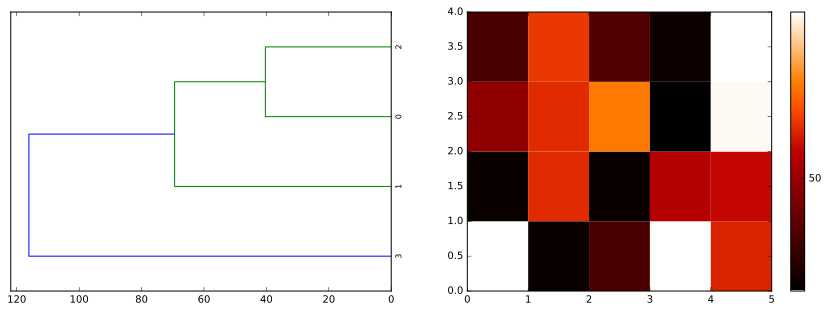

In [52]:
a = [[48,63,74,21,92] , [23,63,23,55,58], [35,65,36,24,93], [93,23,35,93,62]]
print a
#a = np.array(a)
#print a + .5
#print a.T
#a[3] = 5
#print a
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

d = linkage(a, 'ward')
dendout = dendrogram(d,leaf_rotation=90.,leaf_font_size=8.,orientation='left', ax=ax1)
newMatrix = []
for i in dendout['ivl']:
    newMatrix.append(a[int(i)])
print dendout['ivl']

im = ax2.pcolormesh(newMatrix, cmap='gist_heat')  # Plot the variance data
plt.colorbar(im, ticks=[0, 50, 100])
plt.show()
#

In [27]:
a = [4,6,7,2,9]
print [i+.5 for i in a]

[4.5, 6.5, 7.5, 2.5, 9.5]


In [37]:
for i in range(5):
    if i == 3:
        continue
    elif i > 0:
        print i
    else:
        print 'a'

a
1
2
4


In [11]:
a = [[48,63,74,21,92] , [23,63,23,55,58], [35,65,36,24,93], [93,23,35,93,62]]
print a
for i in a:
    i[3] = 9999999
    print i
    if i[1] == 65:
        print True
        i = []
print a

[[48, 63, 74, 21, 92], [23, 63, 23, 55, 58], [35, 65, 36, 24, 93], [93, 23, 35, 93, 62]]
[48, 63, 74, 9999999, 92]
[23, 63, 23, 9999999, 58]
[35, 65, 36, 9999999, 93]
True
[93, 23, 35, 9999999, 62]
[[48, 63, 74, 9999999, 92], [23, 63, 23, 9999999, 58], [35, 65, 36, 9999999, 93], [93, 23, 35, 9999999, 62]]


In [17]:
a = 2.299
print round(a)

2.0
